Total samples : 419509
Mean of x : 25.80962289781127
Std of x : 18.503064345501244
a_r : 0.30000000000000004
b_r : 0.8999999999999999
Mean of z : 25.801325453003013
Std of z : 18.513509719601263

Optimized Parameters
mu : 25.801325453003013
lambda : 0.0014587890131696967
c : 0.021548711440552787
Integral over ±6 sigma : 0.9999999980268246


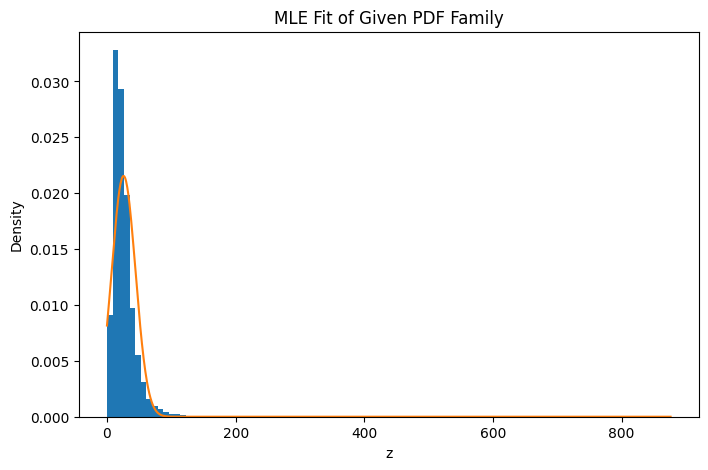

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import trapezoid


# we load the datatset

df = pd.read_csv(
    r"D:\Code\GitHub\PDF-Estimator\DATA\data.csv",
    encoding="cp1252",
    engine="python"
)


x = df["no2"]


x = x.dropna()


x = pd.to_numeric(x, errors="coerce")
x = x.dropna()


x = x.values


print("Total samples :", len(x))
print("Mean of x :", np.mean(x))
print("Std of x :", np.std(x))



r = 102303592 # my roll number


# given transform
a_r = 0.05 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r :", a_r)
print("b_r :", b_r)

z = x + a_r * np.sin(b_r * x)

print("Mean of z :", np.mean(z))
print("Std of z :", np.std(z))



n = len(z)

def neg_log_likelihood(params):
    
    mu = params[0]
    lam = params[1]
    
    if lam <= 0:
        return np.inf
    
    term1 = - (n/2) * np.log(lam)
    term2 = (n/2) * np.log(np.pi)
    term3 = lam * np.sum((z - mu)**2)
    
    return term1 + term2 + term3


mu0 = np.mean(z)
lam0 = 1 / (2 * np.var(z))

res = minimize(
    neg_log_likelihood,
    x0=[mu0, lam0],
    method="L-BFGS-B",
    bounds=[(None, None), (1e-10, None)]
)

mu_opt = res.x[0]
lam_opt = res.x[1]
c_opt = np.sqrt(lam_opt / np.pi) # integral of pdf mmust be 1, from there we get c as function of lambda


print("\nOptimized Parameters")
print("mu :", mu_opt)
print("lambda :", lam_opt)
print("c :", c_opt)


z_check = np.linspace(
    mu_opt - 6*np.std(z),
    mu_opt + 6*np.std(z),
    200000
)

pdf_vals = c_opt * np.exp(-lam_opt * (z_check - mu_opt)**2)

area = trapezoid(pdf_vals, z_check)

print("Integral over ±6 sigma :", area)


# for visualization of our fit

z_range = np.linspace(min(z), max(z), 1000)
pdf_curve = c_opt * np.exp(-lam_opt * (z_range - mu_opt)**2)

plt.figure(figsize=(8,5))
plt.hist(z, bins=100, density=True)
plt.plot(z_range, pdf_curve)
plt.title("MLE Fit of Given PDF Family")
plt.xlabel("z")
plt.ylabel("Density")


plt.savefig("../images/hist_fit.png", dpi=300, bbox_inches="tight")

plt.show()
